In [1]:
from tensorflow.keras import Sequential
from keras.layers import *
from keras.losses import MeanSquaredLogarithmicError
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.constraints import MaxNorm
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import recall_score,accuracy_score,precision_score
import numpy as np
import matplotlib.pyplot as plt

#read train data
data_path = r'C:\Users\name\OneDrive\Documents\Computer Science Masters\Independent Research Project\Summative Assessment\Artefact Directory\cnp_train_data.xlsx'
df_normal = pd.read_excel(data_path,sheet_name='Train')
X = df_normal.drop(['target'], axis=1)
print(X.shape)

#scale train data
scaler = MinMaxScaler()
scaler.fit(X)
data = scaler.transform(X)

#read test data
data_path_test = r'C:\Users\name\OneDrive\Documents\Computer Science Masters\Independent Research Project\Summative Assessment\Artefact Directory\cnp_final_test_data.xlsx'
df_FinalTest = pd.read_excel(data_path_test,sheet_name='Test')
X_test = df_FinalTest.drop(['target'], axis=1)

#scale test data
data_test = scaler.transform(X_test)

#run the Autoencoder algorithm 3 times and take the average reconstruction loss, accuracy, recall and precision
recon_loss_avg = 0
accuracy = 0
recall = 0
precision = 0
recon_error_norm_full = []
recon_error_test_full = []
for j in range(3):

    #early stopping
    callback = tf.keras.callbacks.EarlyStopping(monitor='binary_crossentropy', patience=3)
    
    #Autoencoder
    encoder = Sequential()
    encoder.add(Input(shape=(25,)))
    encoder.add(Dense(16-2,activation='relu',kernel_initializer='he_uniform', kernel_constraint=MaxNorm(3)))
    encoder.add(Dropout(0.4))
    encoder.add(Dense(11+1,activation='relu',kernel_initializer='he_uniform', kernel_constraint=MaxNorm(2)))
    encoder.add(Dropout(0.9)) 
    encoder.add(Dense(4+3,activation='relu',kernel_initializer='he_uniform', kernel_constraint=MaxNorm(2)))

    decoder = Sequential()
    decoder.add(Dense(6+0,activation='relu',kernel_initializer='he_uniform', kernel_constraint=MaxNorm(2)))
    decoder.add(Dropout(0.9))
    decoder.add(Dense(11-2,activation='relu',kernel_initializer='he_uniform', kernel_constraint=MaxNorm(3)))
    decoder.add(Dropout(0.0))
    decoder.add(Dense(16+3,activation='relu',kernel_initializer='he_uniform', kernel_constraint=MaxNorm(3)))
    decoder.add(Dropout(0.7))
    decoder.add(Dense(25,activation='sigmoid'))

    #compile autoencoder and fit on training data
    autoencoder = Sequential([encoder,decoder])
    autoencoder.compile(loss='binary_crossentropy',optimizer='adam',metrics=[tf.keras.losses.BinaryCrossentropy()]) #FILL IN BRACKETS
    autoencoder.fit(data,data, batch_size=20, epochs=50, verbose=0, callbacks=[callback])
    
    #predict on training data and take reconstruction loss
    pred_data_norm = autoencoder.predict(data)
    reconstruction_error_norm_AUTO = tf.keras.losses.BinaryCrossentropy()
    recon_loss = reconstruction_error_norm_AUTO(pred_data_norm,data).numpy()
    recon_loss_avg += recon_loss
    reconstruction_error_norm = tf.keras.losses.BinaryCrossentropy(reduction=tf.keras.losses.Reduction.NONE)
    reconstruction_error_norm = reconstruction_error_norm(pred_data_norm,data)
    
    #predict on test data
    pred_data_test = autoencoder.predict(data_test)
    reconstruction_error_test = tf.keras.losses.BinaryCrossentropy(reduction=tf.keras.losses.Reduction.NONE)
    reconstruction_error_test = reconstruction_error_test(pred_data_test,data_test)
    
    recon_error_norm_full = recon_error_norm_full + reconstruction_error_norm.numpy().tolist()
    recon_error_test_full = recon_error_test_full + reconstruction_error_test.numpy().tolist()
    anomaly_indexes = [i for i,x in enumerate(df_FinalTest['target']) if x == 1]
    normal_indexes = [i for i,x in enumerate(df_FinalTest['target']) if x == 0]
    recon_error_test_anomalies = [recon_error_test_full[i] for i in anomaly_indexes]
    recon_error_test_normal = [recon_error_test_full[i] for i in normal_indexes]
    
    #define threshold and calculate accuracy, recall and precision
    threshold = recon_loss + 0.4
    pred_test = tf.math.less(reconstruction_error_test, threshold)
    pred_test = [1 if i==False else 0 for i in pred_test]
    print(list(pred_test).count(1))
    
    accuracy += accuracy_score(df_FinalTest['target'], pred_test)
    recall += recall_score(df_FinalTest['target'], pred_test)
    precision += precision_score(df_FinalTest['target'], pred_test)

recon_loss_avg = recon_loss_avg/3
accuracy = accuracy/3
recall = recall/3
precision = precision/3
print("Reconstruction Loss: " + str(recon_loss_avg))
print("Accuracy: " + str(accuracy))
print("Recall: " + str(recall))
print("Precision: " + str(precision))

(10027, 25)
65/65 [==============================] - 0s 3ms/step
653
65/65 [==============================] - 0s 1ms/step
627
65/65 [==============================] - 0s 1ms/step
906
Reconstruction Loss: 0.738901856969342
Accuracy: 0.6772639691714836
Recall: 0.6880341880341879
Precision: 0.14952324968647734


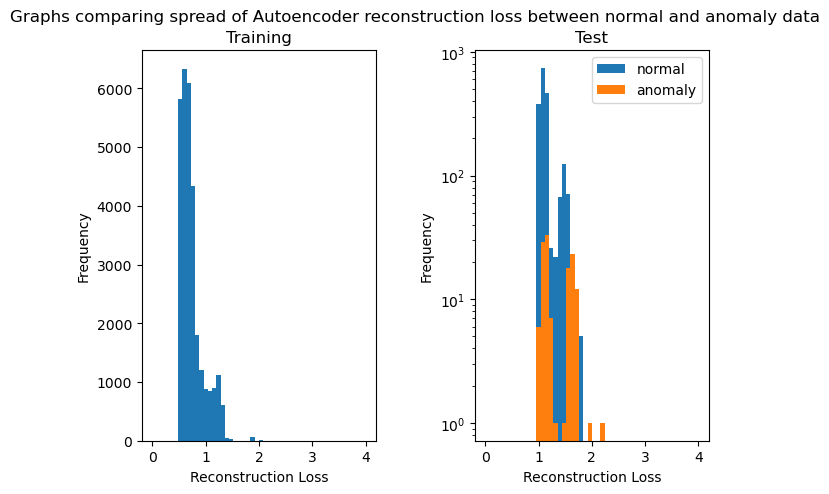

In [2]:
#graphs showing reconstruction loss distribution
figure, axis = plt.subplots(1, 2)
figure.suptitle("Graphs comparing spread of Autoencoder reconstruction loss between normal and anomaly data")
figure.tight_layout(w_pad=4.0)
axis[0].hist(recon_error_norm_full,bins=50,range=[0,4])
axis[0].set(xlabel="Reconstruction Loss",ylabel="Frequency")
axis[0].title.set_text('Training')
axis[1].hist(recon_error_test_normal,bins=50,range=[0,4],label='normal')
axis[1].hist(recon_error_test_anomalies,bins=50,range=[0,4],label='anomaly')
axis[1].set(xlabel="Reconstruction Loss",ylabel="Frequency")
axis[1].title.set_text('Test')
axis[1].legend(loc='upper right')
axis[1].semilogy()
plt.show()